# Logistic Regression Assignment on Amazon Food Review

# Introduction

Logistic regression is used widely to examine and describe the relationship between a binary response variable (e.g., ‘success’ or ‘failure’) and a set of predictor variables. In common with linear regression (e.g., Linear Hypothesis: Regression (Basics)), the primary objective of logistic regression is to model the mean of the response variable, given a set of predictor variables

## Objective:
#### To Predict the Polarity of Amazon Fine Food Review Using Naive-Bayes Algorithm

#### Apply Naive Bayes Algorithm on
1. Bow(Bag of Words)
2. TF-IDF
3. Average Word2Vec
4. tf-idf Word2Vec

#### Try out both L1 & L2 regularization
#### Try out pertubation test
#### Calculate sparsity on weight vector obtained after using L1 regularization
#### Properly document the results according to the instructions provided in the corresponding ipynb

### [Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review

### Steps :

#### We will perform following steps for classifying the review as positive or Negative:
##### 1.Importing data 
##### 2.Preparing that data
##### 3.Choosing a model
##### 4.Training
##### 5.Evaluation
##### 6.Hyperparameter tuning
##### 7.Prediction.

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing
from sklearn import metrics

In [3]:
import math
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score

In [4]:
import sqlite3
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Logistic_Regression_Data where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [5]:
print("Number of Reviews: ",Data["Text"].count())
print("Number of Users: ",len(Data["UserId"].unique())) 
print("Number of Products: ",len(Data["ProductId"].unique()))
print("Shape of Data: ",Data.shape)
print("\n",Data.columns)
print("Number of Attributes/Columns in data: 12") 
print("Number of Positive Reviews : ", Data['Score'].value_counts()[1])
print("Number of Negative Reviews : ", Data['Score'].value_counts()[0])

Number of Reviews:  150000
Number of Users:  115887
Number of Products:  42869
Shape of Data:  (150000, 13)

 Index(['level_0', 'index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')
Number of Attributes/Columns in data: 12
Number of Positive Reviews :  126413
Number of Negative Reviews :  23587


In [6]:
# Sorting on the basis of Time Parameter
Data.sort_values('Time',inplace=True)
Data = Data.sample(n=100000)
Data['Score'].value_counts()
X = Data['CleanedText'].values
y = Data['Score'].values

In [1]:
Data.head()

NameError: name 'Data' is not defined

## Splitting the data into train and test set

In [7]:
#splitting
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size = 0.33,shuffle='false')

In [8]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(67000,) (67000,)
(33000,) (33000,)


## Hyperparameter

In [9]:
c= {'C':[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

## Reusable codes

In [10]:
#confusion matrix
def confusionmatrix(model,X,y):
    ob = confusion_matrix(y,model.predict(X))
    label = ['NEGATIVE','POSITIVE']
    df = pd.DataFrame(ob,index=label,columns=label)
    sns.heatmap(df,annot=True,fmt ='d')

In [11]:
#findbestparameter
def findbestparameter(model,X,y,param):
    parameter = {'C':[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':[param]}
    tscv = TimeSeriesSplit(n_splits=10)
    gs = GridSearchCV(model,parameter,verbose=1,scoring='roc_auc',cv=tscv)
    gs.fit(X,y)
    return gs

In [12]:
#auc-curve
def plot_auc(gscv):
    
    results=gscv.cv_results_
    train_auc=[1-x for x in results['mean_train_score']]
    cv_auc=[1 - x for x in results['mean_test_score']]
    
    log_c=[math.log10(x) for x in c['C'] ]
    plt.plot(log_c, train_auc, label='Train AUC')
    plt.plot(log_c, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("Log(c): hyperparameter")
    plt.ylabel("Missclassification Error")
    plt.title("Plot Between Missclassification Error & Log(c)")
    plt.show()

In [13]:
#imporntantfeatures
def important_features(vectorizer,model,n=10):
    
    Weights_Index = model.coef_[0].argsort()
    length = len(Weights_Index)
    # For Negative Class
    neg_class=Weights_Index[:10]
    
    neg_feat=[vectorizer.get_feature_names()[x] for x in neg_class]
    neg_prob=[model.coef_[0][x] for x in neg_class]
    
    neg_zip=list(zip(neg_feat,neg_prob))
    neg_zip.sort()
    
    # For Positive Class 
    pos_class =  Weights_Index[-10:]
    
    pos_feat=[vectorizer.get_feature_names()[x] for x in pos_class]
    pos_prob=[model.coef_[0][x] for x in pos_class]
    pos_zip=list(zip(pos_feat,pos_prob))
    pos_zip.sort()
    
    top=zip(pos_zip,neg_zip)
    
    print("{0:20}{1:55}{2:20}".format("S.N","Positive","Negative"))
    print("_"*90)
    i=1
    for (fn_1,coef_1), (fn_2,coef_2) in top:
        print("%d.\t\t%.3f\t%-30s\t\t%.3f\t%s" % (i,coef_1, fn_1, coef_2, fn_2))
        i+=1
    

In [14]:
#Plot ROC_AUC Curve

def plot_auc_roc(model,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("Alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

# Bags of Words

In [15]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_bow = preprocessing.normalize(vect.transform(X_train))
X_test_bow = preprocessing.normalize(vect.transform(X_test))

print("Shape of Train and Test Data After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

Shape of Train and Test Data After vectorizations
(67000, 31622) (67000,)
(33000, 31622) (33000,)


### L1 Regularization

In [21]:
model = LogisticRegression(class_weight='balanced')

In [20]:
gsv = findbestparameter(model,X_train_bow,y_train,'l1')

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 52.1min finished


In [22]:
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Accuracy: 93.48%


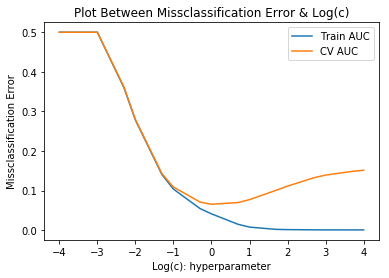

In [30]:
plot_auc(gsv)

In [32]:
Best_param=gsv.best_params_
model =LogisticRegression(C=Best_param['C'],penalty='l1',class_weight='balanced')
model.fit(X_train_bow,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Confusion Matrices

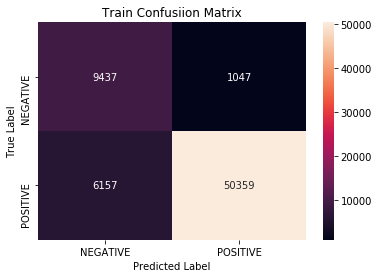

In [34]:
#ploting Confusion matrix
confusionmatrix(model,X_train_bow,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

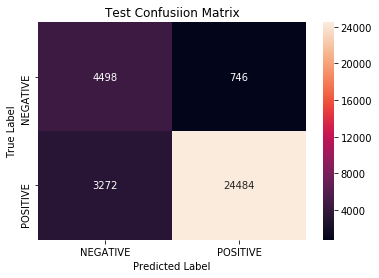

In [35]:
#ploting Confusion matrix
confusionmatrix(model,X_test_bow,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC Curve

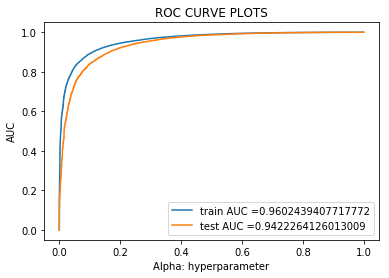

In [36]:
plot_auc_roc(model,X_train_bow,X_test_bow,y_train,y_test)

### Classification Report

In [37]:
print("Classification Report: \n")
y_pred=model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.58      0.86      0.69      5244
           1       0.97      0.88      0.92     27756

   micro avg       0.88      0.88      0.88     33000
   macro avg       0.77      0.87      0.81     33000
weighted avg       0.91      0.88      0.89     33000



### 10 most important feature

In [43]:
important_features(vect,model,n=10)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		9.278	addict                        		-14.570	aw
2.		8.670	amaz                          		-11.607	cancel
3.		10.009	delici                        		-10.221	disappoint
4.		9.623	heaven                        		-10.913	disgust
5.		11.794	hook                          		-10.130	gross
6.		8.854	perfect                       		-11.141	horribl
7.		9.376	skeptic                       		-11.990	tasteless
8.		9.018	smooth                        		-13.490	terribl
9.		9.231	terrif                        		-10.512	threw
10.		9.298	worri                         		-16.846	worst


### L2 Regularizaion

In [38]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_bow = preprocessing.normalize(vect.transform(X_train))
X_test_bow = preprocessing.normalize(vect.transform(X_test))

print("Shape of Train and Test Data After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

Shape of Train and Test Data After vectorizations
(67000, 31659) (67000,)
(33000, 31659) (33000,)


In [39]:
model = LogisticRegression(class_weight='balanced')
gsv = findbestparameter(model,X_train_bow,y_train,'l2')

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 13.5min finished


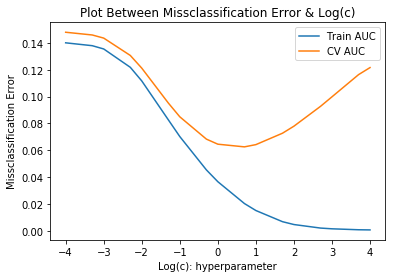

In [46]:
plot_auc(gsv)

In [40]:
Best_param=gsv.best_params_
model =LogisticRegression(C=Best_param['C'],penalty='l2',class_weight='balanced')
model.fit(X_train_bow,y_train)

LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

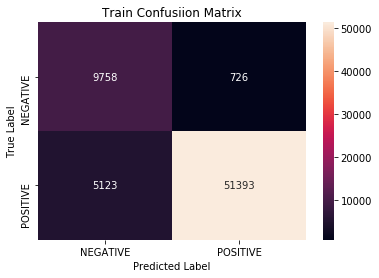

In [48]:
#ploting Confusion matrix
confusionmatrix(model,X_train_bow,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

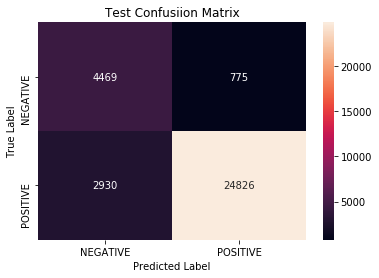

In [49]:
#ploting Confusion matrix
confusionmatrix(model,X_test_bow,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC Curve

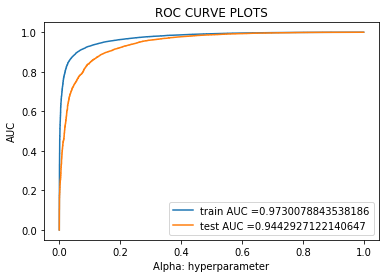

In [50]:
plot_auc_roc(model,X_train_bow,X_test_bow,y_train,y_test)

### Classification Report

In [51]:
print("Classification Report: \n")
y_pred=model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.60      0.85      0.71      5244
           1       0.97      0.89      0.93     27756

   micro avg       0.89      0.89      0.89     33000
   macro avg       0.79      0.87      0.82     33000
weighted avg       0.91      0.89      0.90     33000



### 10 important feature

In [52]:
important_features(vect,model,n=10)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		8.431	addict                        		-12.234	aw
2.		8.145	amaz                          		-9.022	bland
3.		8.220	awesom                        		-9.756	cancel
4.		8.376	best                          		-10.194	disappoint
5.		9.839	delici                        		-8.767	disgust
6.		7.870	excel                         		-10.038	horribl
7.		9.002	hook                          		-9.647	tasteless
8.		8.769	perfect                       		-12.085	terribl
9.		8.541	smooth                        		-9.175	threw
10.		7.975	worri                         		-13.533	worst


# Tf-idf

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [16]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
X_train_tfidf = preprocessing.normalize(vectorizer.transform(X_train))
X_test_tfidf = preprocessing.normalize(vectorizer.transform(X_test))

### L1 Regularization

In [18]:
model = LogisticRegression(class_weight='balanced')
gsv = findbestparameter(model,X_train_tfidf,y_train,'l1')

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 91.6min finished


In [19]:
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Accuracy: 93.33%


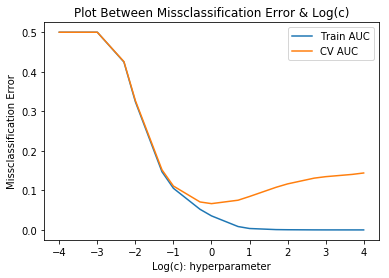

In [21]:
plot_auc(gsv)

In [29]:
Best_param=gsv.best_params_
model =LogisticRegression(C=Best_param['C'],penalty='l1',class_weight='balanced')
model.fit(X_train_tfidf,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Confusion Matrix

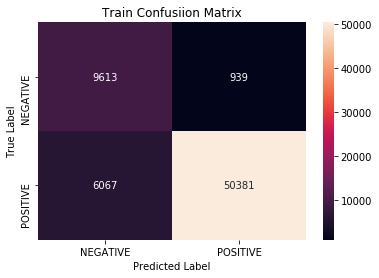

In [30]:
#ploting Confusion matrix
confusionmatrix(model,X_train_tfidf,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

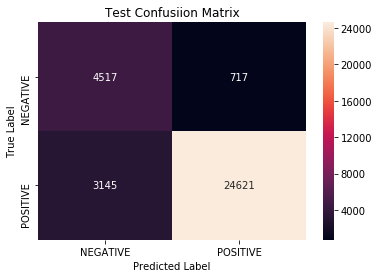

In [31]:
#ploting Confusion matrix
confusionmatrix(model,X_test_tfidf,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC Curve

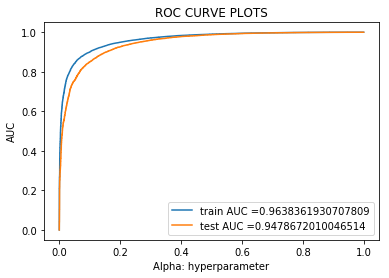

In [32]:
plot_auc_roc(model,X_train_tfidf,X_test_tfidf,y_train,y_test)

### Classification Report

In [33]:
print("Classification Report: \n")
y_pred=model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.59      0.86      0.70      5234
           1       0.97      0.89      0.93     27766

   micro avg       0.88      0.88      0.88     33000
   macro avg       0.78      0.87      0.81     33000
weighted avg       0.91      0.88      0.89     33000



### 10 important features

In [34]:
important_features(vectorizer,model,n=10)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		8.589	amaz                          		-11.611	aw
2.		9.169	awesom                        		-11.044	disappoint
3.		12.344	best                          		-8.093	greed
4.		14.427	delici                        		-9.085	horribl
5.		10.460	excel                         		-7.920	intelligensia
6.		13.192	great                         		-7.815	opposit
7.		9.666	hook                          		-8.829	return
8.		11.302	love                          		-9.734	terribl
9.		11.402	perfect                       		-9.583	unaccept
10.		8.483	yum                           		-13.833	worst


### L2 Regularization

In [19]:
model = LogisticRegression(class_weight='balanced')
gsv = findbestparameter(model,X_train_tfidf,y_train,'l2')

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  9.1min finished


In [20]:
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'C': 1, 'penalty': 'l2'}
Best Accuracy: 93.90%


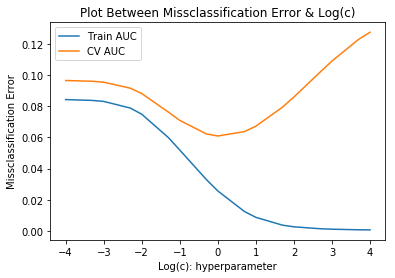

In [21]:
plot_auc(gsv)

In [22]:
Best_param=gsv.best_params_
model =LogisticRegression(C=Best_param['C'],penalty='l2',class_weight='balanced')
model.fit(X_train_tfidf,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Confusion Matrices

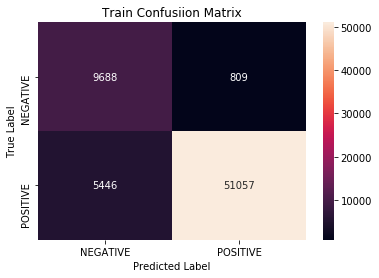

In [23]:
#ploting Confusion matrix
confusionmatrix(model,X_train_tfidf,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

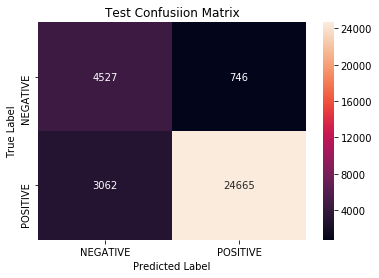

In [24]:
#ploting Confusion matrix
confusionmatrix(model,X_test_tfidf,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC Curve

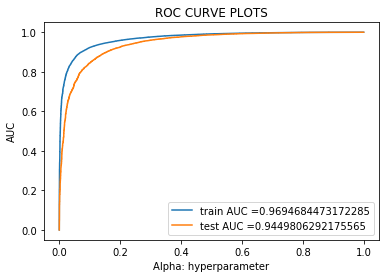

In [25]:
plot_auc_roc(model,X_train_tfidf,X_test_tfidf,y_train,y_test)

In [ ]:
print("Classification Report: \n")
y_pred=model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

### 10 important feature

In [27]:
important_features(vectorizer,model,n=10)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		5.822	amaz                          		-7.167	aw
2.		6.287	awesom                        		-5.473	bland
3.		9.701	best                          		-9.296	disappoint
4.		9.710	delici                        		-5.943	horribl
5.		7.172	excel                         		-4.957	refund
6.		6.062	good                          		-6.231	return
7.		11.121	great                         		-6.266	terribl
8.		9.123	love                          		-4.901	unfortun
9.		9.348	perfect                       		-5.529	weak
10.		6.080	yummi                         		-7.828	worst


# Word2Vec

In [15]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [16]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [17]:
model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)

## Av. Word2Vec

In [18]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [19]:
Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)   

In [20]:
print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (33000, 50)


In [21]:
X_train_w2v=Train_vectors
X_test_w2v=Test_vectors

### L1 Regularization

In [25]:
model = LogisticRegression(class_weight='balanced')
gsv = findbestparameter(model,X_train_w2v,y_train,'l1')

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 36.1min finished


In [24]:
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'C': 5, 'penalty': 'l1'}
Best Accuracy: 90.44%


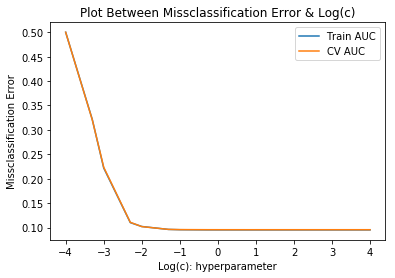

In [25]:
plot_auc(gsv)

In [27]:
Best_param=gsv.best_params_
model =LogisticRegression(C=Best_param['C'],penalty='l1',class_weight='balanced')
model.fit(X_train_w2v,y_train)

LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

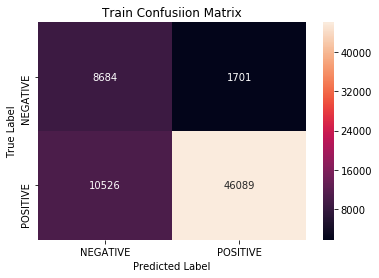

In [27]:
#ploting Confusion matrix
confusionmatrix(model,X_train_w2v,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

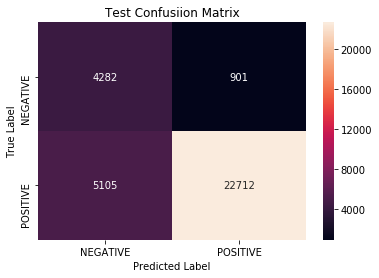

In [28]:
#ploting Confusion matrix
confusionmatrix(model,X_test_w2v,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

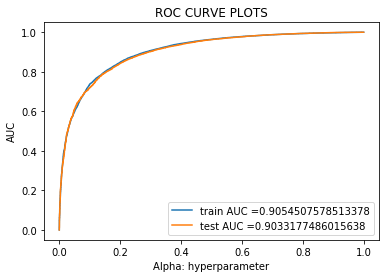

In [30]:
plot_auc_roc(model,X_train_w2v,X_test_w2v,y_train,y_test)

In [31]:
print("Classification Report: \n")
y_pred=model.predict(X_test_w2v)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.46      0.83      0.59      5183
           1       0.96      0.82      0.88     27817

   micro avg       0.82      0.82      0.82     33000
   macro avg       0.71      0.82      0.74     33000
weighted avg       0.88      0.82      0.84     33000



## TF-IDF weighted Word2Vec

In [26]:
model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)

In [27]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [28]:
X_train_tfidf = preprocessing.normalize(vectorizer.transform(X_train))
X_test_tfidf = preprocessing.normalize(vectorizer.transform(X_test))

In [29]:
tfidf_Feature=vectorizer.get_feature_names()
print(len(tfidf_Feature))
print(tfidf_Feature[0:20])

31622
['aaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaaawsom', 'aaaallll', 'aaaand', 'aaah', 'aadd', 'aaf', 'aafco', 'aah', 'aahh', 'aamzon', 'aap', 'aargh', 'ab', 'aback', 'abalon', 'abamectin']


In [30]:
from tqdm import tqdm
Train_Vectors=[]
row=0
for sent in tqdm(list_of_Train_sent):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=model.wv[word]
            tfidf_vec=X_train_tfidf[row,tfidf_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_Vectors.append(sent_vec) 
    row+=1

100%|████████████████████████████████████| 67000/67000 [40:08<00:00, 36.31it/s]


In [38]:
Test_Vectors=[]
row=0
for sent in tqdm(list_of_Test_sent):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=model.wv[word]
            tfidf_vec=X_Test_Tfidf(row,tfidf_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_Vectors.append(sent_vec)    
    row+=1

100%|██████████████████████████████████| 33000/33000 [00:03<00:00, 8835.58it/s]


X_train = np.nan_to_num(Train_Vectors)
X_test = np.nan_to_num(Test_Vectors)
X_train_tfidfw2v = X_train_w2v
X_test_tfidfw2v = X_testv_w2v

In [29]:
X_train_tfidfw2v = X_train_w2v
X_test_tfidfw2v = X_test_w2v

### L1 Regularization

In [30]:
model = LogisticRegression(class_weight='balanced')
gsv = findbestparameter(model,X_train_tfidfw2v,y_train,'l1')

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 27.5min finished


In [31]:
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'C': 0.5, 'penalty': 'l1'}
Best Accuracy: 90.32%


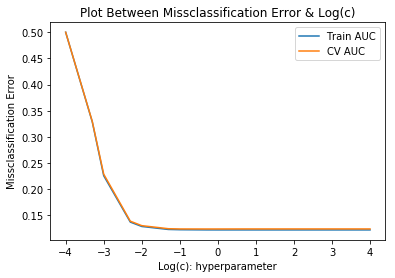

In [42]:
plot_auc(gsv)

In [33]:
Best_param=gsv.best_params_
model =LogisticRegression(C=Best_param['C'],penalty='l1',class_weight='balanced')
model.fit(X_train_tfidfw2v,y_train)

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

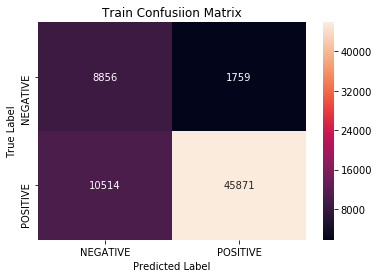

In [30]:
#ploting Confusion matrix
confusionmatrix(model,X_train_tfidfw2v,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

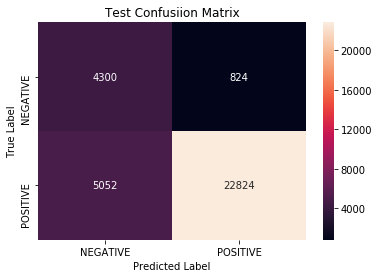

In [32]:
#ploting Confusion matrix
confusionmatrix(model,X_test_tfidfw2v,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

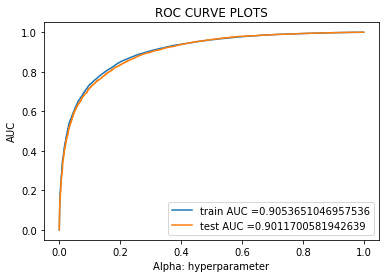

In [34]:
plot_auc_roc(model,X_train_tfidfw2v,X_test_tfidfw2v,y_train,y_test)

In [34]:
print("Classification Report: \n")
y_pred=model.predict(X_test_tfidfw2v)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.46      0.84      0.59      5124
           1       0.97      0.82      0.89     27876

   micro avg       0.82      0.82      0.82     33000
   macro avg       0.71      0.83      0.74     33000
weighted avg       0.89      0.82      0.84     33000



### L2 Regularization

In [49]:
model = LogisticRegression(class_weight='balanced')
gsv = findbestparameter(model,X_train_tfidfw2v,y_train,'l2')

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  2.4min finished


In [50]:
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'C': 0.1, 'penalty': 'l2'}
Best Accuracy: 87.58%


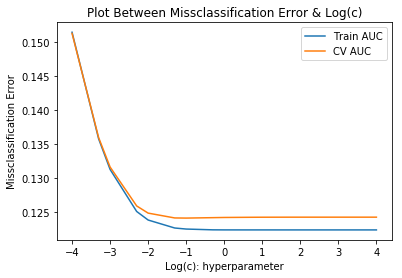

In [51]:
plot_auc(gsv)

In [52]:
Best_param=gsv.best_params_
model =LogisticRegression(C=Best_param['C'],penalty='l2',class_weight='balanced')
model.fit(X_train_tfidfw2v,y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

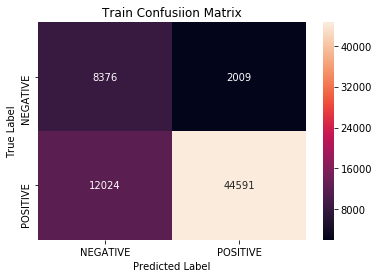

In [53]:
#ploting Confusion matrix
confusionmatrix(model,X_train_tfidfw2v,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

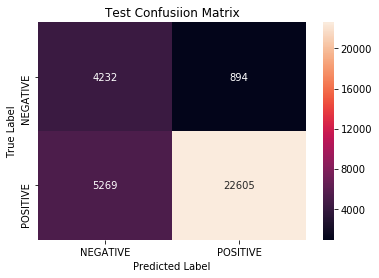

In [36]:
#ploting Confusion matrix
confusionmatrix(model,X_test_tfidfw2v,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

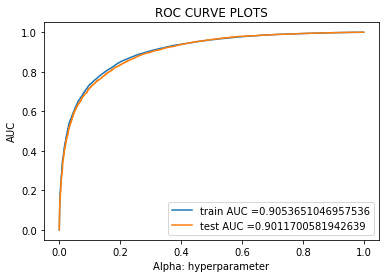

In [35]:
plot_auc_roc(model,X_train_tfidfw2v,X_test_tfidfw2v,y_train,y_test)

In [57]:
print("Classification Report: \n")
y_pred=model.predict(X_test_tfidfw2v)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.16      1.00      0.27      5183
           1       0.00      0.00      0.00     27817

   micro avg       0.16      0.16      0.16     33000
   macro avg       0.08      0.50      0.14     33000
weighted avg       0.02      0.16      0.04     33000



### Perbutaion Test

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [16]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
X_train_tfidf = preprocessing.normalize(vectorizer.transform(X_train))
X_test_tfidf = preprocessing.normalize(vectorizer.transform(X_test))

In [18]:
model =LogisticRegression(C=1,penalty='l1',class_weight='balanced')
model.fit(X_train_tfidf,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [19]:
from scipy.sparse import find
W = find(model.coef_[0])[2]
print(W[:50])

[ 0.40298706  0.33374083  0.83238193 -2.70359777 -0.26405715 -1.38521163
 -0.27851927  0.14397931  0.51173282  0.82913129  0.22416805 -0.16056806
  0.22117096  4.20459708  7.77915858  2.05129409  0.805595   -0.8322694
  0.01491755 -1.12489186  0.99688579  2.41623425  0.86563168  2.84100609
 -2.65600182  0.02643149  0.90089878 -2.36141963 -0.99186191  1.08630494
 -0.06701998 -1.03365227 -1.65250265 -5.71450408 -0.04776504  2.8593493
  0.16038254 -0.62896372 -0.90011037  1.72643067  1.01205207  0.3671124
  0.38562843 -4.75947627  1.51813583  0.7017318  -1.13024056 -0.07765713
  4.07428565  8.24527536]


In [20]:
X_trainp = X_train_tfidf
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_trainp)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_trainp)

#Introducing random noise to non-zero datapoints
X_trainp[a,b] = epsilon + X_trainp[a,b]

In [21]:
lr= LogisticRegression(C=1, penalty= 'l1',class_weight='balanced')
lr.fit(X_trainp,y_train)
y_pred = lr.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 88.282%
Non Zero weights: 2081


In [22]:
#Weights after adding random noise
W2 = find(lr.coef_[0])[2]
print(W2[:50])

[ 0.40423075  0.3342682   0.83246417 -2.7019278  -0.26439293 -1.38228321
 -0.27927936  0.14382061  0.51329686  0.82925031  0.22301318 -0.16038826
  0.22496361  4.20375196  7.77952561  2.05201679  0.80549682 -0.83258643
  0.01434536 -1.12575631  0.99489086  2.41717268  0.86509647  2.84145734
 -2.65557646  0.02671088  0.90184106 -2.36029877 -0.99163739  1.08653034
 -0.07019909 -1.03312152 -1.65267075 -5.71322129 -0.04893747  2.85893724
  0.16040336 -0.62887666 -0.9003406   1.72746739  1.01173009  0.36627593
  0.38491576 -4.75978541  1.51799562  0.70226992 -1.12848629 -0.07614071
  4.07384939  8.2458134 ]


In [25]:
# W : normal Weigths
# W2  Weights after adding noice

#adding a small value to eliminate divide by zero error
W = W + 10**-6 
W2 = W2 +10**-6

### Percentage change vector between W and W'

In [45]:
c = abs( (W-W2) / (W)) * 100
c

array([3.08616942e-01, 1.58016996e-01, 9.87991015e-03, ...,
       1.07722300e-04, 7.61753310e-02, 7.04050328e-01])

In [46]:
curr = 0
for i in range (100):
    x = np.percentile(c, i)
    if abs(x-curr)>2.5:
        print("There is sudden rise in %age difference in" ,i ,"th percentile")
    curr =x

There is sudden rise in %age difference in 99 th percentile


### Sparsity and l1 regularization

In [1]:
C = [0.0001,0.001,0.01,0.1,1,10,100,1000,1000]

In [35]:
for c in C:
    model = LogisticRegression(C=c,penalty ='l1',class_weight = 'balanced')
    model.fit(X_train_tfidf,y_train)
    y_pred = model.predict(X_test_tfidf)
    print("C = ",c)
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("f1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
    print("Non Zero weights:",np.count_nonzero(model.coef_))
    print("######################################################################################################")

C =  0.001
Accuracy on test set: 15.636%
f1-Score on test set: 0.000
Non Zero weights: 0
######################################################################################################
C =  0.01
Accuracy on test set: 65.170%
f1-Score on test set: 0.751
Non Zero weights: 20
######################################################################################################
C =  0.1
Accuracy on test set: 83.839%
f1-Score on test set: 0.897
Non Zero weights: 300
######################################################################################################
C =  1
Accuracy on test set: 87.948%
f1-Score on test set: 0.925
Non Zero weights: 2072
######################################################################################################
C =  10
Accuracy on test set: 88.500%
f1-Score on test set: 0.930
Non Zero weights: 8292
######################################################################################################
C =  100
Accuracy on test set: 86.570%
f1

In [41]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "hyperparameter(C)","Train AUC","Test AUC","f1-Score"]

x.add_row(["BOW",1,0.96,0.94,0.89])
x.add_row(["TF-IDF",1,0.96,0.95,0.85])
x.add_row(["Avg W2V",5,0.90,0.90,0.88])
x.add_row(["TF-IDF W2V",0.5,0.88,0.50,0.05])

print(x)

+------------+-------------------+-----------+----------+----------+
| Vectorizer | hyperparameter(C) | Train AUC | Test AUC | f1-Score |
+------------+-------------------+-----------+----------+----------+
|    BOW     |         1         |    0.96   |   0.94   |   0.89   |
|   TF-IDF   |         1         |    0.96   |   0.95   |   0.85   |
|  Avg W2V   |         5         |    0.9    |   0.9    |   0.88   |
| TF-IDF W2V |        0.5        |    0.88   |   0.5    |   0.05   |
+------------+-------------------+-----------+----------+----------+


In [42]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "hyperparameter(C)","Train AUC","Test AUC","f1-Score"]

x.add_row(["BOW",5,0.97,0.94,0.93])
x.add_row(["TF-IDF",1,0.97,0.94,0.93])
x.add_row(["Avg W2V",0.05,0.90,0.90,0.83])
x.add_row(["TF-IDF W2V",0.1,0.88,0.50,0.05])

print(x)

+------------+-------------------+-----------+----------+----------+
| Vectorizer | hyperparameter(C) | Train AUC | Test AUC | f1-Score |
+------------+-------------------+-----------+----------+----------+
|    BOW     |         5         |    0.97   |   0.94   |   0.93   |
|   TF-IDF   |         1         |    0.97   |   0.94   |   0.93   |
|  Avg W2V   |        0.05       |    0.9    |   0.9    |   0.83   |
| TF-IDF W2V |        0.1        |    0.88   |   0.5    |   0.05   |
+------------+-------------------+-----------+----------+----------+


# Observations

1. Tf-idf Vectorizer has outperformed other vectorizers.
2. L2 Regularizer is giving slightly better result than L1 Regularizer
3. Since the dataset is imbalanced we used class_weight = 'balanced' attribute
4. Saprsity increases with increase in C
5. Words like awesome , best , great etc are important in positive reviews also words like dissappoint , horrible ,refund , weak etc are important in negative class.
6. Logistic Regression has ourperformed both knn and naive bayes algorithm